In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.special import jv
from scipy.interpolate import interp2d
from scipy.stats import norm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from tqdm import tqdm
from os import listdir
from os.path import isfile, join

plt.close('all') 
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 15 
plt.rcParams["font.family"] = "Arial"
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Constants

In [2]:
global pi, h, hbar, c, eps0, m, lam, k, gamma, tau, Is, delta, w1, w2, Ipcf, w3, Ptot, Itot
global tau_sp, gamma_sp, ng, ne, gamma_eff
pi = np.pi
h = 6.62607004e-34
hbar = h/(2*pi)
c = 299792458
eps0 = 8.854e-12

m = 6.6551079E-26*41/40 # mass of a CaH molecule
lam = 695e-9
k = 2*pi/lam

tau_sp = 33e-9 # spontaneous lifetime
gamma_sp = 1 / tau_sp * 0.968
ng = 12
ne = 4    
gamma_eff = gamma_sp  * ne / (ng + ne) * 1 #.45 is measured rate, from deflection
Is = pi * h * c / (3 * lam**3 * tau_sp) * 2 * ng**2 / (ng + ne)

# Define useful functions

In [3]:
def init(n_par,vf,dvf,r,T):
    """
    This is beam initialization.Spatially, it starts from a round aperture at uniform distribution, where the radius is defined by r.
    In terms of velocity, the forward velocity is a gaussian type with center vel "vf" and width "dvf".
    The transverse velocity follows Maxwell-Boltzman distribution at temperature "T".
    """
    std = np.sqrt(1.38e-23*T/m)
    z = np.full(n_par, 0)
    vz = np.random.normal(vf,dvf,n_par)
    
    radius=np.sqrt(np.random.random(n_par))*r
    angle= np.random.random(n_par)*pi*2
    x = radius*np.cos(angle)
    y = radius*np.sin(angle)

    speed=np.sqrt(np.random.random(n_par))*std
    angle= np.random.random(n_par)*pi*2
    vx = np.random.randn(n_par)*std
    vy = np.random.randn(n_par)*std
    return np.array([x,y,z,vx,vy,vz])

def prop_free(mol, time, reach_detector_length):
    """
    This simulates molecules propogates freely in space until it reach the detector. The condition of each molecules
    about whether it has reached detector is saved in a list "reach_detector_length". If it has reached, it stops.
    """
    for i in range(len(mol[1])):
        if reach_detector_length[i]<1:
            mol[0,i] = mol[3,i] * time + mol[0,i]
            mol[1,i] = mol[4,i] * time + mol[1,i]
            mol[2,i] = mol[5,i] * time + mol[2,i]
    
def detector(mol, z_detector, r_detector, reach_detector_length, hit_detector):
    """
    This is to examine each molecules if it has reached the detector.
    """
    for i in range(len(mol[0,:])):
        if mol[2,i]>z_detector:
            reach_detector_length[i]=1
            if np.abs(mol[1,i])<r_detector:
                hit_detector[i]=1
    return reach_detector_length, hit_detector

def plot_beam_profile(mol,detecter=False):
    """
    This is to plot the spatial distribution of the beam in x-y plane at a given time.If detecter==True, it only plots the molecules
    that hit on the detector.
    """
    plt.figure(figsize=(4,4))
    if detecter==False:
        pltmax = np.max([mol[1]])
        plt.hist2d(mol[0],mol[1],bins=64,range=[[-pltmax,pltmax],[-pltmax,pltmax]])
    else:
        plt.hist2d(mol[0][hit_detector>0],mol[1][hit_detector>0],bins=64,range=[[-4E-2, 4E-2], [-6E-3, 6E-3]])
    plt.show()
    
def plot_vel_profile(mol,detecter=False):
    """
    This is to plot the x and y velocity distribution of the beam at a given time.If detecter==True, it only plots the molecules
    that hit on the detector.
    """
    f, ax = plt.subplots(1,3,figsize=(15,3))
    for i in range(3):
        ax[i].hist(mol[i+3],bins=100)
        ax[i].set_title(f'{i} direction velocity distribution')
        ax[i].set_xlabel('vel (m/s)')
    plt.show()
    
def depletion_beam(mol, t_step,R_max, photon_counter, L=0.1, r=1.3E-3):
    """
    This is to calculate number of photons that can be scattered with a known scattering rate, can be used to calculate scattering rate."""
    for i in range(len(mol[0,:])):
        if mol[2,i]<L:
            photon_counter[i]+=t_step*R_max*np.exp(-0.5*mol[1,i]**2/r**2)
            
def gaussian(x,aa,bb,cc,dd):
    """
    This is a fit function.
    """
    hold=aa+bb*np.exp(-0.5*(x-cc)**2/dd**2)
    return hold

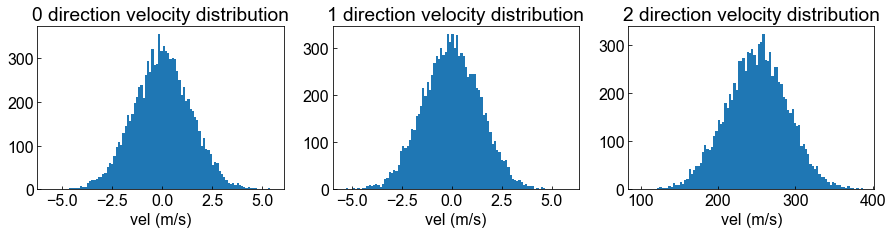

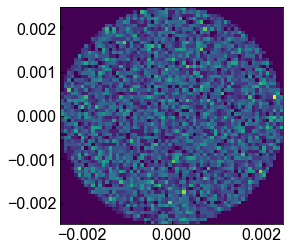

In [4]:
n_par = 10000
vForward = 250
spreadForward = 40
r_cell = 0.0025;
T_transverse = 0.01
t_step=1E-5;
t_max=40E-3;
n_step=int(t_max/t_step)

mol_store = []
reach_detector_length = np.zeros(n_par)
hit_detector = np.zeros(n_par)
photon_counter = np.zeros(n_par)
I_list = []

mol = init(n_par,vForward,spreadForward,r_cell,T_transverse)
plot_vel_profile(mol)
plot_beam_profile(mol,detecter=False)

# Define function that calculates Sisyphus force at any known spatial position

In [6]:
data_temp = np.load('1.00_Gs_Bfield_20MHz_det.npz')
var_input = data_temp['var_input']
scndvar_list = data_temp['scndvar_list']
force_storage = data_temp['force_storage']
sisyphus_from_OBE = interp2d(var_input,scndvar_list, force_storage)

def Sisyphus_acce(vx,z_pos,y_pos,Zdop1,SF_global=1,SF_Doppler=1):
    sgn = np.sign(vx)   #this determins it's Sisyphus cooling or heating
    vel_x = np.abs(vx)
    num_pass = (Zdop1-z_pos)/2E-3  # for a particle, use its z coordinate to calculate the order of light beam it is passing through
    wy = 0.84E-3*np.sqrt(1+(num_pass*0.3/3.19)**2) #gaussian beam width in y direction
    wx = 0.55E-3*np.sqrt(1+(num_pass*0.3/1.367)**2) #gaussian beam width in x direction
    Imax = 2600  #this is max intensity used in experiment
    Imax_mol = 2600  #this is max intensity seen by molecules
    Ireal = Imax_mol * (0.84E-3/wy) * (0.55E-3/wx) * np.exp(-2*y_pos**2/wx/wy) * SF_global
    windowfct = 0.982**num_pass  #laser will lose power everytime it passes through the interaction chamber
    Ireal = Ireal*windowfct
    SFreal = np.sqrt(Ireal/Imax)
    sisphus_OBE = sisyphus_from_OBE(vel_x,SFreal) #based on the x velocity and laser intensity, do a 2d interpolation to calculate the acceleration (from OBE code)
    if np.sign(sisphus_OBE)<0:
        sisphus_OBE = SF_Doppler*sisphus_OBE
    acce = 1*sgn*sisphus_OBE
    return acce, [Ireal, num_pass]  #returns an acceleration and intensity information that each molecule experiences.

In [7]:
def transverse_beam(mol, time, reach_detector_length, Zdop1, Zdop2, Zsis1, Zsis2, I_list):
    for i in range(len(mol[1])):
        if reach_detector_length[i]<1:
            if mol[2,i]<Zdop1 and mol[2,i]>Zdop2:
                Acce = 0 #Assume doppler force is weak compared to Sisyphus.
            elif mol[2,i]<Zsis1 and mol[2,i]>Zsis2:
                Acce, Ireal = Sisyphus_acce(mol[3,i],mol[2,i],mol[1,i],Zdop1,SF_global=1,SF_Doppler=1)
                I_list.append(Ireal)
            else:
                Acce = 0
            mol[0,i] = Acce*0.5*time**2 + mol[3,i] * time + mol[0,i]
            mol[1,i] = mol[4,i] * time + mol[1,i]
            mol[2,i] = mol[5,i] * time + mol[2,i]        
            mol[3,i] = Acce*time + mol[3,i]

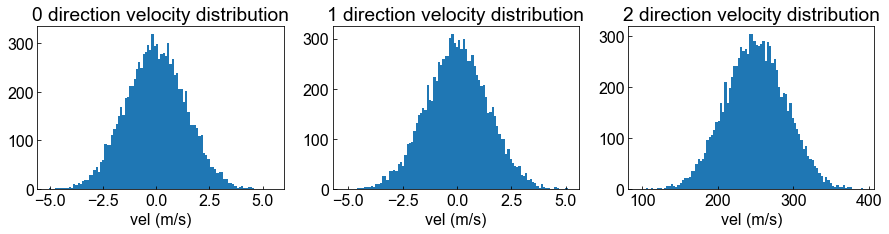

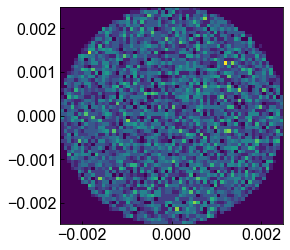

 12%|█████████▍                                                                     | 479/3999 [00:22<02:45, 21.32it/s]


0.00479


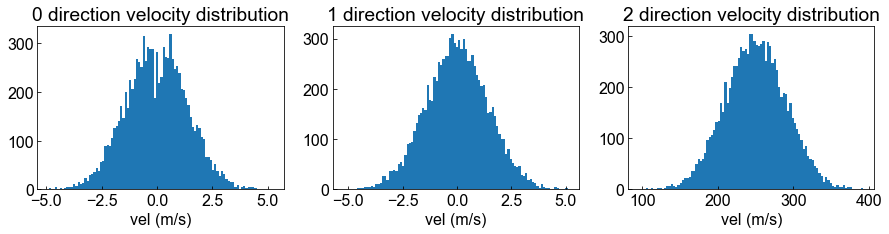

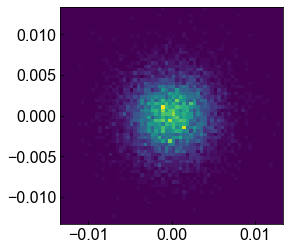

In [9]:
# beam initialization
n_par = 10000
vForward = 250
spreadForward = 40
r_cell = 0.0025;
T_transverse = 0.01
t_step=1E-5;
t_max=40E-3;
n_step=int(t_max/t_step)

mol_store = []
reach_detector_length = np.zeros(n_par)
hit_detector = np.zeros(n_par)
photon_counter = np.zeros(n_par)
I_list = []

mol = init(n_par,vForward,spreadForward,r_cell,T_transverse)
plot_vel_profile(mol)
plot_beam_profile(mol,detecter=False)

# beam traveling and experience Sisyphus force in Sisyphus region
for i in tqdm(range(n_step)):
    transverse_beam(mol, t_step, reach_detector_length, 0.12, 0.07, 0.07, 0, I_list)
    [reach_detector_length, hit_detector] = detector(mol, 0.46, 0.002, reach_detector_length, hit_detector)
    if np.min(reach_detector_length)==1:
        print(i*t_step)
        break
    
plot_vel_profile(mol)
plot_beam_profile(mol,detecter=False)
I_list = np.array(I_list)

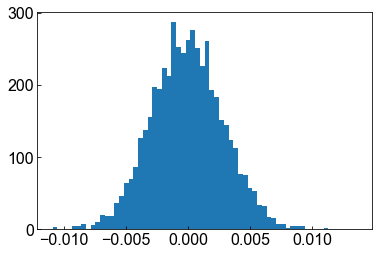

In [10]:
plt.hist(mol[0][hit_detector>0],bins=64)
plt.show()

[ 1.85767963e-01  1.39547197e+02 -9.99817262e-05  2.85180113e-03]


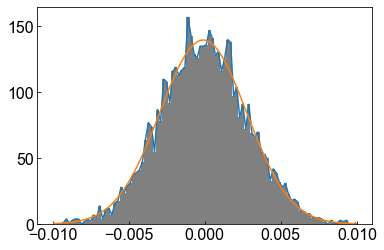

In [11]:
binrangeset = [-0.04, 0.04]
binrangeset = [-0.01, 0.01]

[hist,binedges] = np.histogram(mol[0][hit_detector>0],bins=100,range=binrangeset)

x = 0.5*binedges[1:]+0.5*binedges[0:-1]
y = hist
def gaussian(x,aa,bb,cc,dd):
    hold=aa+bb*np.exp(-0.5*(x-cc)**2/dd**2)
    return hold
fill=np.linspace(min(x),max(x),100)
popt,pcov = curve_fit(gaussian, x, y, p0=[0 , np.max(y) , x[np.argmax(y)], 0.003])
perr = np.sqrt(np.diag(pcov))
print(popt)
########### the outputs are : y offset, amplitude, x offset, width  ###########
########### square root of 'pcov' is the error for each parameter   ###########

# f,ax = plt.subplots(1,1, figsize=(10,4))
# ax.plot(x, y, label="original")
plt.plot(0.5*binedges[1:]+0.5*binedges[0:-1],hist)
plt.hist(mol[0][hit_detector>0],bins=100,range=binrangeset,color='gray')
plt.plot(fill,gaussian(fill,*popt), label = 'fitted')

plt.show()

# Below is to generate beam width change vs B field plot.

In [281]:
def Sisyphus_acce(vx,z_pos,y_pos,Zdop1,SF_global=1,SF_Doppler=1,acc_dir=-1,beam_spacing=2E-3):
    sgn = np.sign(vx)
    vel_x = np.abs(vx)
    num_pass = (Zdop1-z_pos)/beam_spacing
    wy = 0.84E-3*np.sqrt(1+(num_pass*0.3/3.19)**2)
    wx = 0.55E-3*np.sqrt(1+(num_pass*0.3/1.367)**2)
    Imax = 2600  #this is max intensity used in experiment
    Imax_mol = 2600  #this is max intensity seen by molecules
    Ireal = Imax_mol * (0.84E-3/wy) * (0.55E-3/wx) * np.exp(-2*y_pos**2/wx/wy) * SF_global
    windowfct = 0.982**num_pass
    Ireal = Ireal*windowfct
    SFreal = np.sqrt(Ireal/Imax)
    sisphus_OBE = sisyphus_from_OBE(vel_x,SFreal)
    if np.sign(sisphus_OBE)<0:
        sisphus_OBE = SF_Doppler*sisphus_OBE
    acce = -1*acc_dir*sgn*sisphus_OBE
    return acce, [Ireal, num_pass]


def transverse_beam(mol, time, reach_detector_length, Zdop1, Zdop2, Zsis1, Zsis2, I_list, 
                    negpos=1, SF_global_input=1, SF_Doppler_input=1, spacing_input=2E-3):
    for i in range(len(mol[1])):
        if reach_detector_length[i]<1:
            if mol[2,i]<Zdop1 and mol[2,i]>Zdop2:
                Acce = 0#Doppler_acce() not finished
            elif mol[2,i]<Zsis1 and mol[2,i]>Zsis2:
                Acce, Ireal = Sisyphus_acce(mol[3,i],mol[2,i],mol[1,i],Zdop1,
                                            SF_global=SF_global_input,SF_Doppler=SF_Doppler_input,
                                            acc_dir=negpos,beam_spacing=spacing_input)
                I_list.append(Ireal)
            else:
                Acce = 0
            mol[0,i] = Acce*0.5*time**2 + mol[3,i] * time + mol[0,i]
            mol[1,i] = mol[4,i] * time + mol[1,i]
            mol[2,i] = mol[5,i] * time + mol[2,i]        
            mol[3,i] = Acce*time + mol[3,i]

In [282]:
filename = 'bfield_files\\4(20Mhz)\\'
onlyfiles = [f for f in listdir(filename) if isfile(join(filename, f))]
onlyfiles=[x for x in onlyfiles if 'npz' in x]
det_list = [float(onlyfiles[_].split('__')[0]) for _ in range(len(onlyfiles))]
print(det_list)

[7.0, 6.0, 0.8, 5.0, 0.6, 0.4, 4.0, 0.2, 8.0, 3.0, 2.0, 1.0, 0.0]


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

bfield_files\4(20Mhz)\7.00__Gs_Bfield_20MHz_fixedcode_2022_02_21_08_25_31.npz
0.00472


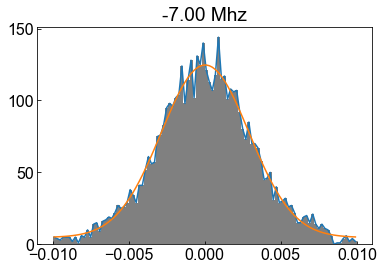

2.890197660529135 0.06214338317244286
0.00472


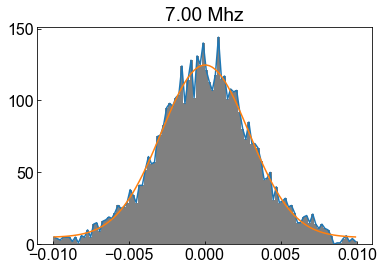

  8%|██████▎                                                                           | 1/13 [02:00<24:06, 120.53s/it]

2.890197660529135 0.06214338317244286
bfield_files\4(20Mhz)\6.00__Gs_Bfield_20MHz_fixedcode_2022_02_21_05_48_06.npz
0.00472


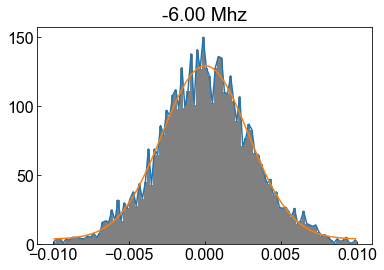

2.8328729113547313 0.07267239719008108
0.00472


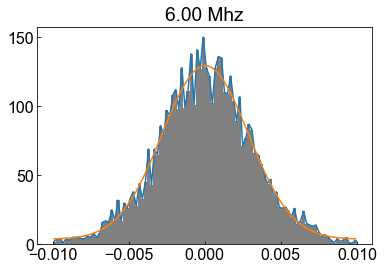

 15%|████████████▌                                                                     | 2/13 [03:57<21:45, 118.68s/it]

2.8328729113547313 0.07267239719008108
bfield_files\4(20Mhz)\0.80__Gs_Bfield_20MHz_fixedcode_2022_02_21_04_12_16.npz
0.00472


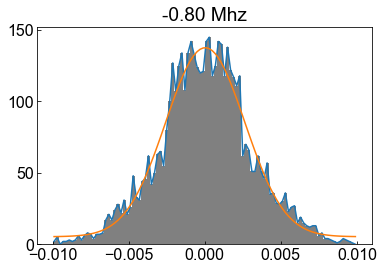

2.5967390228853007 0.07470391326314178
0.00472


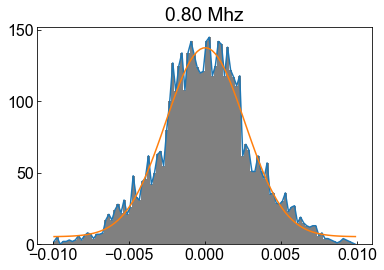

 23%|██████████████████▉                                                               | 3/13 [05:52<19:26, 116.63s/it]

2.5967390228853007 0.07470391326314178
bfield_files\4(20Mhz)\5.00__Gs_Bfield_20MHz_fixedcode_2022_02_21_03_39_07.npz
0.00472


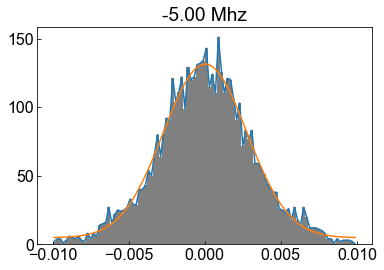

2.741227708832941 0.06025706047020764
0.00472


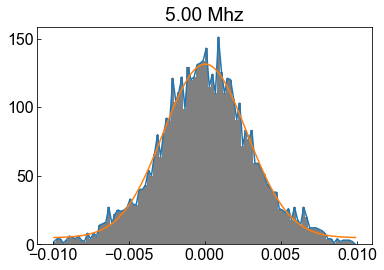

 31%|█████████████████████████▏                                                        | 4/13 [07:49<17:32, 116.96s/it]

2.741227708832941 0.06025706047020764
bfield_files\4(20Mhz)\0.60__Gs_Bfield_20MHz_fixedcode_2022_02_21_03_23_07.npz
0.00472


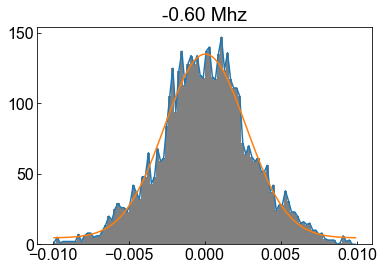

2.6822116450759514 0.07109378607798165
0.00472


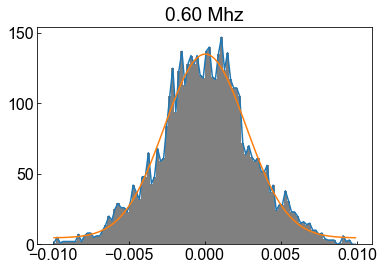

 38%|███████████████████████████████▌                                                  | 5/13 [09:42<15:23, 115.46s/it]

2.6822116450759514 0.07109378607798165
bfield_files\4(20Mhz)\0.40__Gs_Bfield_20MHz_fixedcode_2022_02_21_02_34_33.npz
0.00472


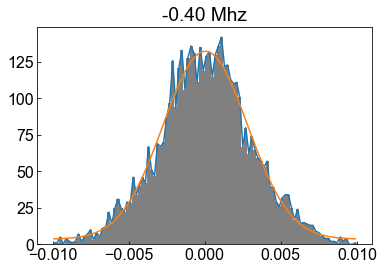

2.7790129292354293 0.06810375556177391
0.00472


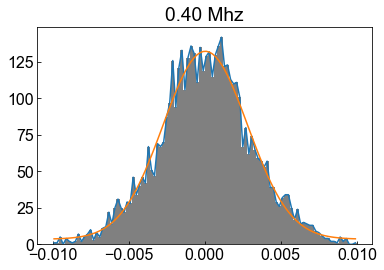

 46%|█████████████████████████████████████▊                                            | 6/13 [11:36<13:26, 115.18s/it]

2.7790129292354293 0.06810375556177391
bfield_files\4(20Mhz)\4.00__Gs_Bfield_20MHz_fixedcode_2022_02_21_01_55_23.npz
0.00472


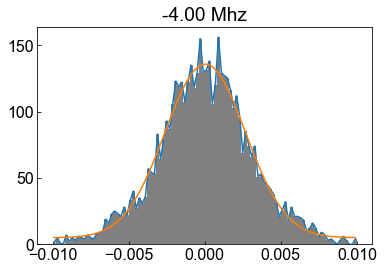

2.6469911514302265 0.062198494857065904
0.00472


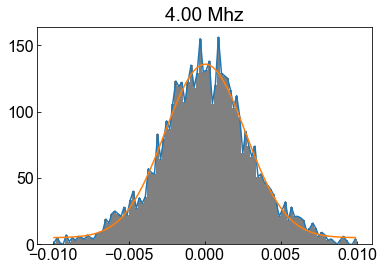

 54%|████████████████████████████████████████████▏                                     | 7/13 [13:32<11:30, 115.15s/it]

2.6469911514302265 0.062198494857065904
bfield_files\4(20Mhz)\0.20__Gs_Bfield_20MHz_fixedcode_2022_02_21_01_46_33.npz
0.00472


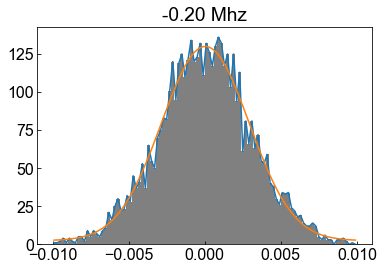

2.8781739845464585 0.06904006644403608
0.00472


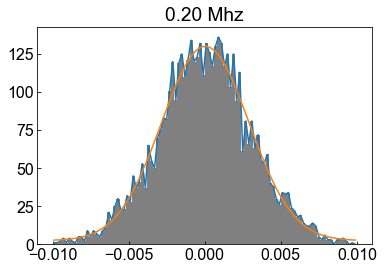

 62%|██████████████████████████████████████████████████▍                               | 8/13 [15:27<09:36, 115.35s/it]

2.8781739845464585 0.06904006644403608
bfield_files\4(20Mhz)\8.00__Gs_Bfield_20MHz_fixedcode_2022_02_21_00_58_57.npz
0.00472


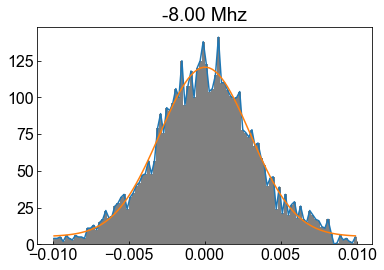

2.966323655803061 0.07420569206379726
0.00472


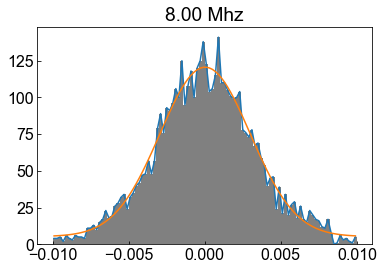

 69%|████████████████████████████████████████████████████████▊                         | 9/13 [17:20<07:37, 114.41s/it]

2.966323655803061 0.07420569206379726
bfield_files\4(20Mhz)\3.00__Gs_Bfield_20MHz_fixedcode_2022_02_21_00_38_03.npz
0.00472


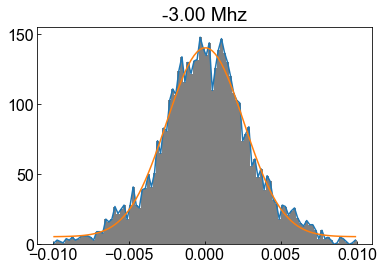

2.5355874396338574 0.05437240160138476
0.00472


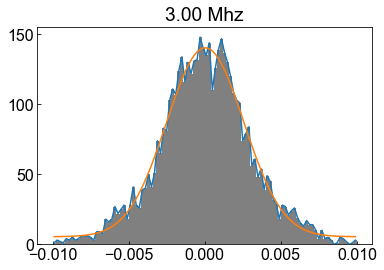

 77%|██████████████████████████████████████████████████████████████▎                  | 10/13 [19:14<05:42, 114.25s/it]

2.5355874396338574 0.05437240160138476
bfield_files\4(20Mhz)\2.00__Gs_Bfield_20MHz_fixedcode_2022_02_20_23_42_29.npz
0.00472


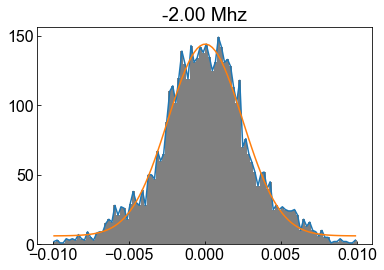

2.4458258331405447 0.055357439422504616
0.00472


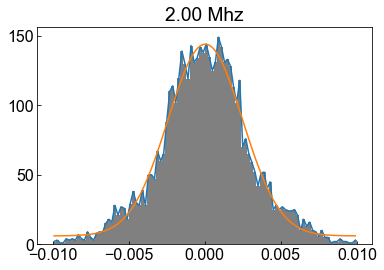

 85%|████████████████████████████████████████████████████████████████████▌            | 11/13 [21:11<03:50, 115.12s/it]

2.4458258331405447 0.055357439422504616
bfield_files\4(20Mhz)\1.00__Gs_Bfield_20MHz_fixedcode_2022_02_20_22_50_57.npz
0.00472


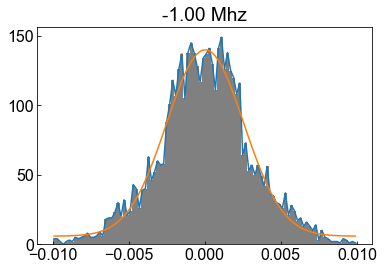

2.530764733085578 0.07254138056263813
0.00472


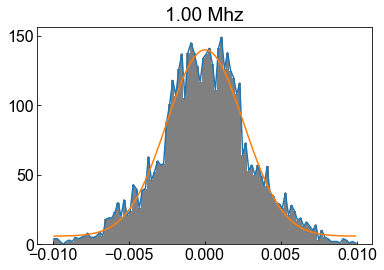

 92%|██████████████████████████████████████████████████████████████████████████▊      | 12/13 [23:02<01:53, 113.96s/it]

2.530764733085578 0.07254138056263813
bfield_files\4(20Mhz)\0.00__Gs_Bfield_10MHz_fixedcode_2022_02_17_18_29_45.npz
0.00472


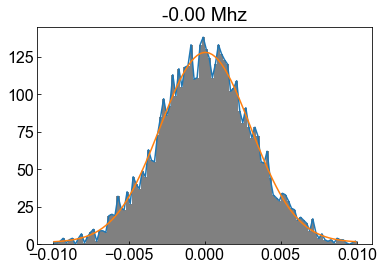

2.9740470460366106 0.05773223764456224
0.00472


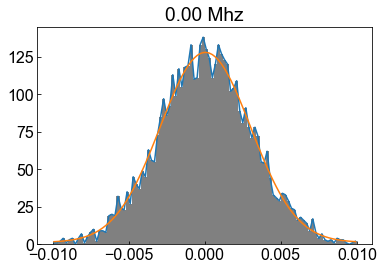

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [24:51<00:00, 114.74s/it]

2.9740470460366106 0.05773223764456224


In [292]:
det_plot_list = []
width_plot_list = []
width_err_list = []

for det_ind in tqdm(range(len(det_list))):#[0,2,3,5,10,11,12]:#
    to_load_file = filename+onlyfiles[det_ind]
    print(to_load_file)
    data_temp = np.load(to_load_file)
    var_input = data_temp['var_input']
    scndvar_list = data_temp['scndvar_list']
    force_storage = data_temp['force_storage']
    sisyphus_from_OBE = interp2d(var_input,scndvar_list, force_storage)
    data_temp.close()  
    for negpos_ind in [-1,1]:
        n_par = 10000
        vForward = 250
        spreadForward = 40
        r_cell = 0.0025;
        T_transverse = 0.011
        t_step=5E-6;
        t_max=40E-3;
        n_step=int(t_max/t_step)
        np.random.seed(1000)

        mol_store = []
        reach_detector_length = np.zeros(n_par)
        hit_detector = np.zeros(n_par)
        photon_counter = np.zeros(n_par)
        I_list = []
        mol = init(n_par,vForward,spreadForward,r_cell,T_transverse)
        for i in range(n_step):
            transverse_beam(mol, t_step, reach_detector_length, 0.08, 0.07, 0.07, 0, I_list,
                            negpos=1, SF_global_input=1, SF_Doppler_input=1, spacing_input=2.4E-3)
            [reach_detector_length, hit_detector] = detector(mol, 0.46, 0.002, reach_detector_length, hit_detector)
            if np.min(reach_detector_length)==1:
                print(i*t_step)
                break
        I_list = np.array(I_list)
        # binrangeset = [-0.04, 0.04]
        binrangeset = [-0.01, 0.01]
        [hist,binedges] = np.histogram(mol[0][hit_detector>0],bins=100,range=binrangeset)
        x = 0.5*binedges[1:]+0.5*binedges[0:-1]
        y = hist
        def gaussian(x,aa,bb,cc,dd):
            hold=aa+bb*np.exp(-0.5*(x-cc)**2/dd**2)
            return hold
        fill=np.linspace(min(x),max(x),100)
        popt,pcov = curve_fit(gaussian, x, y, p0=[0 , np.max(y) , x[np.argmax(y)], 0.003])
        perr = np.sqrt(np.diag(pcov))
    #     print(popt)
        plt.plot(0.5*binedges[1:]+0.5*binedges[0:-1],hist)
        plt.hist(mol[0][hit_detector>0],bins=100,range=binrangeset,color='gray')
        plt.plot(fill,gaussian(fill,*popt), label = 'fitted')
        plt.title(f'{negpos_ind*det_list[det_ind]:.2f} Mhz')
        plt.show()
        print(popt[3]*1E3,perr[3]*1E3)
        det_plot_list.append(negpos_ind*det_list[det_ind])
        width_plot_list.append(popt[3]*1E3)
        width_err_list.append(perr[3]*1E3)

Text(0, 0.5, 'beam width')

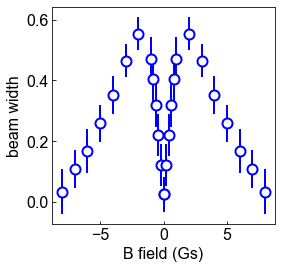

In [293]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.errorbar(det_plot_list,3-np.array(width_plot_list),yerr=width_err_list, fmt='o', mfc = 'w', markeredgewidth=2, elinewidth=2, capsize=0, ms=10, color = 'blue')
plt.xlabel('B field (Gs)')
plt.ylabel('beam width')

In [294]:
# ra1, rb1, rc1= zip(*sorted(zip(det_plot_list, width_plot_list, width_err_list)))

# np.savez('Bfield_sweep_20Mhz_big.npz', det_plot_list=ra1, width_plot_list=rb1, width_err_list=rc1)